
# Анализ вакансий.
## <a href="https://hh.ru/">hh.ru</a> с использованием <a href="https://dev.hh.ru/">официального API</a>.


## Загружаем данные и приводим их к нормальному виду##

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

import requests
from time import sleep
import json

**Исследуем профессию Data Scientist. Найдём как можно больше вакансий по этой профессии в Москве. Имеет смысл искать также по другим ключевым словам, например `аналитик данных`.**

In [ ]:
from tqdm import tqdm

URL = 'https://api.hh.ru/vacancies'

def find_vacancies(vacancy_name, page_number):
    params = {
        'text': vacancy_name,
        'area': 1,
        'page': page_number,
        'per_page': 100
    }
    sleep(0.5)

    req = requests.get(URL, params)
    data = json.loads(req.content.decode())
    return pd.json_normalize(data['items'])


In [ ]:
related_vacancy_names = ['Data science', 'Data scientist', 'Аналитик данных', 'Data analyst']

df = pd.DataFrame()
for page_number in tqdm(range(0, 15)):
    for vacancy_name in related_vacancy_names:
        df = pd.concat([df, find_vacancies(vacancy_name, page_number)], ignore_index=True)

100%|██████████| 15/15 [01:17<00:00,  5.17s/it]


**В полученную выборку некоторые вакансии могли попасть несколько раз. Удалим дубликаты.**

In [ ]:
df.drop_duplicates(subset=['id'], inplace=True, ignore_index=True)

**Загрузим подробное описание каждой вакансии и создадим удобную таблицу данных.**

In [ ]:
def get_detailed_vacancy_info(vacancy_index):
    sleep(0.5)
    vacancy = df['id'].iloc[vacancy_index]
    vacancy_url = f'https://api.hh.ru/vacancies/{vacancy}'

    req = requests.get(vacancy_url)
    vacancy_info = json.loads(req.content.decode())
    return pd.json_normalize(vacancy_info)


In [ ]:
df_detailed = pd.DataFrame()
for vacancy_index in tqdm(range(0, len(df))):
    df_detailed = pd.concat([df_detailed, get_detailed_vacancy_info(vacancy_index)], ignore_index=True)

100%|██████████| 2595/2595 [45:01<00:00,  1.04s/it]


In [ ]:
df_detailed_filtered = df_detailed[['id', 'name', 'key_skills', 'experience.name',
                                    'salary.from', 'salary.to', 'salary.currency', 'salary.gross', 'employer.name',
                                    'address.metro.station_name', 'address.metro.lat', 'address.metro.lng']]
df_detailed_filtered.to_excel("data_frame.xlsx")
df_detailed_filtered

,id,name,key_skills,experience.name,salary.from,salary.to,salary.currency,salary.gross,employer.name,address.metro.station_name,address.metro.lat,address.metro.lng
0,49423067,Data Scientist,"[{'name': 'аналитика'}, {'name': 'SQL'}, {'nam...",От 3 до 6 лет,None,380000.0,RUR,False,Точка,NaN,NaN,NaN
1,54882705,Junior Data scientist/ Младший риск-аналитик,"[{'name': 'Математический анализ'}, {'name': '...",От 1 года до 3 лет,None,NaN,NaN,NaN,Pay P.S.,Динамо,55.789704,37.558212
2,55485778,Data Scientist (Marketplace Efficiency),"[{'name': 'Python'}, {'name': 'Математическая ...",От 3 до 6 лет,NaN,NaN,NaN,NaN,inDriver,NaN,NaN,NaN
3,55358460,Data engineer,"[{'name': 'Python'}, {'name': 'SQL'}, {'name':...",От 3 до 6 лет,3000,None,USD,True,T-DIGITAL,NaN,NaN,NaN
4,55454544,Data engineer,"[{'name': 'Python'}, {'name': 'SQL'}, {'name':...",От 3 до 6 лет,NaN,NaN,NaN,NaN,Сбербанк,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2590,55101205,Бизнес-аналитик (SberData),[],От 3 до 6 лет,NaN,NaN,NaN,NaN,Сбербанк,Тульская,55.709610,37.622569
2591,44557266,Бизнес-аналитик в проектный офис,"[{'name': 'BPMN'}, {'name': 'VBA'}, {'name': '...",От 1 года до 3 лет,175000,None,RUR,True,СК Ренессанс Жизнь,NaN,NaN,NaN
2592,54462196,Ведущий аналитик проекта / бизнес-аналитик,"[{'name': 'SQL'}, {'name': 'UML'}, {'name': 'A...",От 3 до 6 лет,NaN,NaN,NaN,NaN,Лига Цифровой Экономики,Савёловская,55.794054,37.587163
2593,55096197,"Бизнес-аналитик, Внутренние сервисы","[{'name': 'Системность'}, {'name': 'Умение ана...",От 1 года до 3 лет,NaN,NaN,NaN,NaN,Ozon,Выставочная,55.750243,37.542641


##Сколько сейчас вакансий доступно по нашему запросу?##

In [ ]:
len(df_detailed)

2595

##Какие навыки чаще всего встречаются в вакансиях по данной специальности?##

Для этого найдём соответствующее поле в данных, проанализируем его и составим список навыков и количество упоминаний каждого. Визуализируем полученную информацию по топ-15 навыков.

In [ ]:
df_skills = df_detailed[['key_skills']]
list_of_reqs = list()
for index in range(0, len(df_skills)):
    skills = df_skills.iloc[index]
    skills_list = skills.tolist()[0]
    for d in skills_list:
        list_of_reqs.append(list(d.values())[0])
pd_reqs = pd.Series(list_of_reqs)
required_skills = pd_reqs.value_counts().reset_index()

In [ ]:
required_skills.head(10)

,index,0
0,SQL,1141
1,Python,694
2,Анализ данных,441
3,Аналитическое мышление,367
4,MS PowerPoint,339
5,Английский язык,314
6,Бизнес-анализ,212
7,MS SQL,212
8,Работа с большим объемом информации,183
9,BPMN,182


**Строим график**

Text(0.5, 1.0, 'Самые востребованные навыки для аналитика')

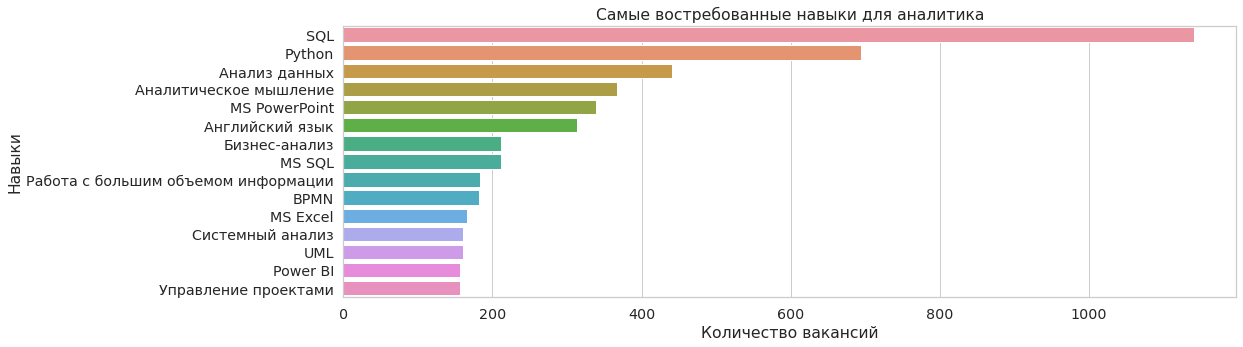

In [ ]:
top_req_skills = required_skills.head(15)
plt.figure(figsize=(16, 5))
sns.barplot(y=top_req_skills['index'], x=top_req_skills[0], orient="h")
plt.xlabel('Количество вакансий')
plt.ylabel('Навыки')
plt.title('Самые востребованные навыки для аналитика')

##Какую зарплату готовы платить работодатели?## 
Соберём статистику и построем гистограмму.

При работе с данными о заработной плате учтём валюту и gross/net. 

Преобразуем данные по заработной плате

In [ ]:
df_salary = df_detailed_filtered
for index in range(0, len(df_salary)):
    # Считаем вычет налогов
    if not pd.isna(df_salary['salary.gross'].iloc[index]):
        if df_salary['salary.gross'].iloc[index] == True:
            df_salary['salary.gross'].iloc[index] == False
            if not pd.isna(df_salary['salary.from'].iloc[index]):
                df_salary['salary.from'].iloc[index] *= 0.87
            if not pd.isna(df_salary['salary.to'].iloc[index]):
                df_salary['salary.to'].iloc[index] *= 0.87

    #Конвертируем валюту
    if not pd.isna(df_salary['salary.currency'].iloc[index]):
        if df_salary['salary.currency'].iloc[index] != "RUB":
            if df_salary['salary.currency'].iloc[index] == "USD":
                if not pd.isna(df_salary['salary.from'].iloc[index]):
                    df_salary['salary.from'].iloc[index] *= 64
                if not pd.isna(df_salary['salary.to'].iloc[index]):
                    df_salary['salary.to'].iloc[index] *= 64
            if df_salary['salary.currency'].iloc[index] == "EUR":
                if not pd.isna(df_salary['salary.from'].iloc[index]):
                    df_salary['salary.from'].iloc[index] *= 67
                if not pd.isna(df_salary['salary.to'].iloc[index]):
                    df_salary['salary.to'].iloc[index] *= 67
            df_salary['salary.currency'].iloc[index] = "RUB"

    # Если указана только одна из границ зарплаты, выставим другую для корректного построения гистограммы

    # Нижняя граница указана
    if not pd.isna(df_salary['salary.from'].iloc[index]) and pd.isna(df_salary['salary.to'].iloc[index]):
        df_salary['salary.to'].iloc[index] = df_salary['salary.from'].iloc[index] * 1.25
    # Верхняя граница указана
    if not pd.isna(df_salary['salary.to'].iloc[index]) and pd.isna(df_salary['salary.from'].iloc[index]):
        df_salary['salary.from'].iloc[index] = df_salary['salary.to'].iloc[index] * 0.75
    
    # Конвертируем в целочисленные значения, потому что с ними проще работать,
    # а на результат анализа это не повлияет
    if not pd.isna(df_salary['salary.to'].iloc[index]):
        df_salary['salary.from'].iloc[index] = int (df_salary['salary.from'].iloc[index])
    if not pd.isna(df_salary['salary.from'].iloc[index]):
        df_salary['salary.to'].iloc[index] = int (df_salary['salary.to'].iloc[index])

# Оставим только вакансии с зарплатой
df_salary = df_salary[df_salary['salary.from'].notna()]

Text(0.5, 1.0, 'Предлагаемая зарплата анилитика данных')

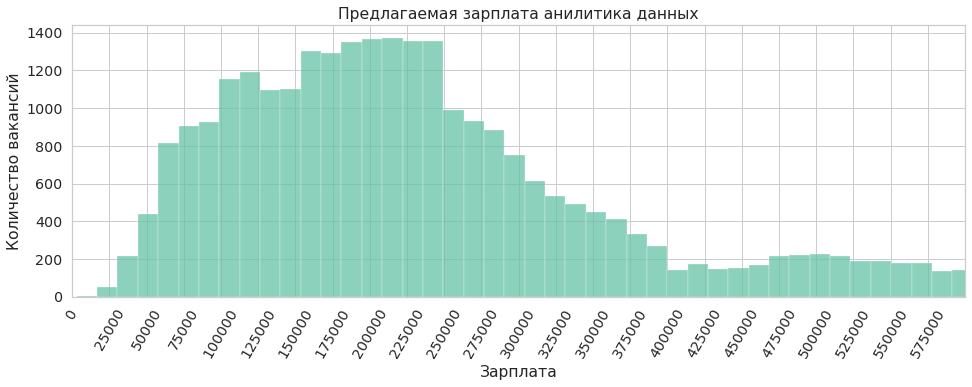

In [ ]:
# Так как визуализировать интервалы зарплат тяжело, перейдем к набору значений в этих интегрвалах
salaries = [rub for index in range(0, len(df_salary)) for rub in range(df_salary['salary.from'].iloc[index], df_salary['salary.to'].iloc[index], 1000)]

# Строим график
plt.figure(figsize=(16, 5))
histplt = sns.histplot(data=salaries)
histplt.set_xticks(range(0, 600000, 25000))
rot = plt.xticks(rotation=60)
plt.xlim(0, 600000)
plt.xlabel('Зарплата')
plt.ylabel('Количество вакансий')
plt.title('Предлагаемая зарплата анилитика данных')

##Какой опыт требуется для вакансии?##

Для анализа опыта работы вначале посмотрим, какие вообще есть требования по этому параметру

In [ ]:
df_exp = df_detailed_filtered['experience.name']
list(df_exp.unique())

['От 3 до 6 лет', 'От 1 года до 3 лет', 'Нет опыта', 'Более 6 лет']

Видим, что сайт позволяет указать лишь определенные промежутки по опыту работы, поэтому для каждого из них посчитаем количество вакансий

In [ ]:
list_of_exp = list()
for index in range(0, len(df_exp)):
    exp = df_exp.iloc[index]
    list_of_exp.append(exp)
pd_exp = pd.Series(list_of_exp)
required_exp = pd_exp.value_counts().reset_index()
required_exp.reindex([2, 3, 0, 1])

,index,0
2,Нет опыта,127
3,Более 6 лет,64
0,От 1 года до 3 лет,1392
1,От 3 до 6 лет,1012


Строим график

Text(0.5, 1.0, 'Требуемый опыт для аналитика')

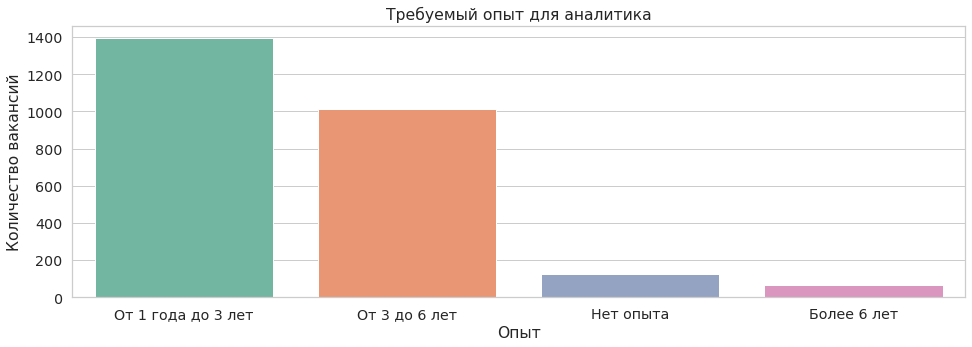

In [ ]:
plt.figure(figsize=(16, 5))
sns.barplot(x=required_exp['index'], y=required_exp[0], orient="v")
plt.xlabel('Опыт')
plt.ylabel('Количество вакансий')
plt.title('Требуемый опыт для аналитика')

##Какие работодатели в топе? ##

Для анализа топа работодателей сделаем то же самое

In [ ]:
df_employer = df_detailed_filtered['employer.name']
list_of_emp = list()
for index in range(0, len(df_employer)):
    emp = df_employer.iloc[index]
    list_of_emp.append(emp)
pd_emp = pd.Series(list_of_emp)
employers = pd_emp.value_counts().reset_index()
employers.head(11)

,index,0
0,Сбербанк,108
1,МТС,54
2,Тинькофф,51
3,VK,36
4,Банк ВТБ (ПАО),36
5,"Иннотех, Группа компаний",36
6,Ozon,32
7,билайн,32
8,HUAWEI,25
9,Лига Цифровой Экономики,23


График

Text(0.5, 1.0, 'Топ работодателей для аналитика')

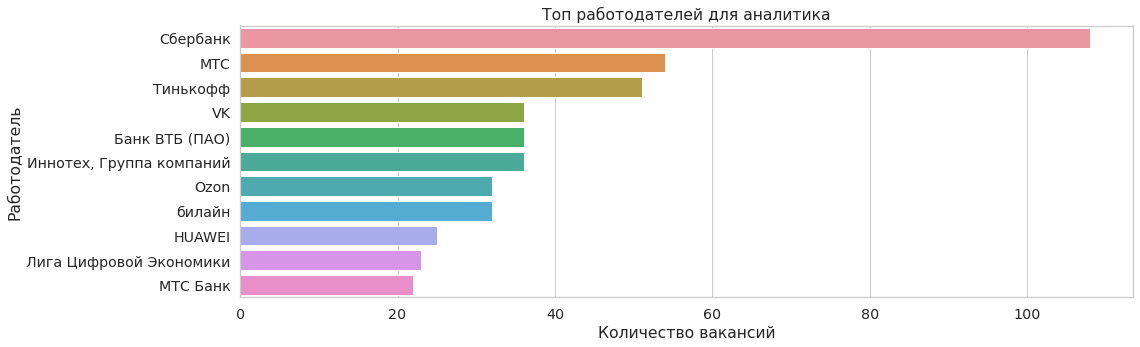

In [28]:
top_employers = employers.head(11)
plt.figure(figsize=(16, 5))
sns.barplot(y=top_employers['index'], x=top_employers[0], orient="h")
plt.xlabel('Количество вакансий')
plt.ylabel('Работодатель')
plt.title('Топ работодателей для аналитика')

##Выводы:##
**Из исследования можно сделать следующие выводы:**
*   В Москве доступно 2600 вакансий аналитика
*   Для аналитика важнейшими навыками явлются python, английский язык и SQL
*   Средняя зарплата аналитика - 200 тысяч рублей
*   Наибольшее число вакансий (1400) требует наличие от 1 до 3 лет опыта, меньше (1000) - от 3 до 6, но есть 130 вакансий, которые вообще не требуют опыта
*   Наибольшее число вакансий предлагают Сбербанк, МТС, Тинькофф